<a href="https://colab.research.google.com/github/Roehrkard/AAI-521-Vehicle-detection-AI-Model/blob/main/Vehicle_Image_classificator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vehicle Classification Using CNN Architectures
This project classifies images as vehicles or non-vehicles using three convolutional neural network (CNN) architectures:

1. Basic CNN - A simple CNN with moderate complexity.
2. Deeper CNN - A deeper architecture for capturing intricate features.
3. Lightweight CNN - An efficient model optimized for speed and simplicity.

## Objective
To compare the performance of different CNN architectures using standard classification metrics and visualization techniques, ensuring the model is robust and effective for vehicle detection tasks.

## Prerequisites
Mounts Google Drive and installs required dependencies.

In [11]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install dependencies
#!pip install -r requirements.txt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from tqdm import tqdm
from IPython.display import Image, display

## Load and Preprocessign Data Functions
Defines a function load_and_preprocess_data to load images from the dataset directory, resize them to a consistent shape of 64×64 pixels, and normalize their pixel values to [0, 1]. It processes two categories: vehicles (labeled 1) and non-vehicles (labeled 0), returning the preprocessed image and label arrays.

In [4]:
def load_and_preprocess_data(data_dir, image_size=(64, 64)):
    images = []
    labels = []

    # Load vehicle images
    vehicle_path = os.path.join(data_dir, 'vehicles')
    for img_name in tqdm(os.listdir(vehicle_path)):
        img_path = os.path.join(vehicle_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            img = img / 255.0  # Normalize
            images.append(img)
            labels.append(1)

    # Load non-vehicle images
    non_vehicle_path = os.path.join(data_dir, 'non-vehicles')
    for img_name in tqdm(os.listdir(non_vehicle_path)):
        img_path = os.path.join(non_vehicle_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            img = img / 255.0  # Normalize
            images.append(img)
            labels.append(0)

    return np.array(images), np.array(labels)

## Plotting & Evualations Functions
This cell includes two main functions: plot_training_history, which visualizes training and validation accuracy and loss to assess model learning, and evaluate_model, which computes and prints classification metrics (accuracy, precision, recall, F1 score). It also visualizes the confusion matrix and ROC curve to analyze model performance.

In [5]:
def plot_training_history(history, model_name='Model'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy plot
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title(f'{model_name} Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Loss plot
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title(f'{model_name} Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

    return fig

def evaluate_model(model, X_test, y_test, model_name='Model'):
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)

    # Calculate metrics
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    tp = conf_matrix[1][1]
    tn = conf_matrix[0][0]
    fp = conf_matrix[0][1]
    fn = conf_matrix[1][0]

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Print metrics
    print(f"\n=== {model_name} Classification Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix Visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred_classes))

    # Return comprehensive evaluation results
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix,
        'roc_auc': roc_auc
    }

## Training Pipeline Function
The train_vehicle_detector function handles the full training pipeline. It loads and preprocesses data, splits it into training, validation, and test sets, compiles the model, and trains it with early stopping to avoid overfitting. After training, the function evaluates the model on the test set and returns results.

In [6]:
def train_vehicle_detector(data_dir, model_fn, image_size=(64, 64), batch_size=32, epochs=20, **model_params):
    # Load and preprocess data
    print("Loading and preprocessing data...")
    X, y = load_and_preprocess_data(data_dir, image_size)

    # Split data
    print("Splitting data into train/validation/test sets...")
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Create and compile model
    print("Creating model...")
    model = model_fn(input_shape=(image_size[0], image_size[1], 3), **model_params)

    # Set up early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    # Train model
    print("Training model...")
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate model
    print("\nEvaluating model...")
    evaluate_model(model, X_test, y_test)

    return model, history, (X_test, y_test)

## Data Directory

In [12]:
# Block 4: Model Training and Evaluation
working_dir = '/content/drive/My Drive/colab_datasets/AAI-521-Final/data'

# working_dir = '/content/drive/My Drive/Colab Notebooks/Computer_Vision/Project/AAI-521-Final/data'

## Model Functions
Defines three CNN architectures tailored for different needs: Basic CNN (moderate complexity with three Conv2D layers), Deeper CNN (more layers and filters to capture intricate features), and Lightweight CNN (fewer layers and filters for efficiency). Each architecture uses a similar sequential structure with convolutional, pooling, and dense layers.

In [9]:
def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

def train_basic_cnn():
    model, history, (X_test, y_test) = train_vehicle_detector(
        data_dir=working_dir,
        model_fn=create_cnn_model,
        image_size=(64, 64),
        batch_size=32,
        epochs=20
    )
    # Plot training history
    plot_training_history(history, model_name='Basic CNN')

    # Evaluate model
    evaluate_model(model, X_test, y_test, model_name='Basic CNN')

def create_deeper_cnn(input_shape, filters=[32, 64, 128, 256], dense_units=[128, 64]):
    """
    Create a deeper CNN model with configurable parameters
    """
    model = Sequential()

    # First conv layer
    model.add(Conv2D(filters[0], (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    # Additional conv layers
    for filter_size in filters[1:]:
        model.add(Conv2D(filter_size, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    # Dense layers
    for units in dense_units:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    return model

def train_deeper_cnn():
    model, history, (X_test, y_test) = train_vehicle_detector(
        data_dir=working_dir,
        model_fn=create_deeper_cnn,
        image_size=(64, 64),
        batch_size=32,
        epochs=20,
        filters=[32, 64, 128, 256],
        dense_units=[128, 64]
    )
    # Plot training history
    plot_training_history(history, model_name='Deeper CNN')

    # Evaluate model
    evaluate_model(model, X_test, y_test, model_name='Deeper CNN')

def create_lightweight_cnn(input_shape):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    return model

def train_lightweight_cnn():
    model, history, (X_test, y_test) = train_vehicle_detector(
        data_dir=working_dir,
        model_fn=create_lightweight_cnn,
        image_size=(64, 64),
        batch_size=32,
        epochs=20
    )
    # Plot training history
    plot_training_history(history, model_name='Lightweight CNN')

    # Evaluate model
    evaluate_model(model, X_test, y_test, model_name='Lightweight CNN')

## Testing & training Models
The following cells train and evaluate the three CNN architectures. Functions train_basic_cnn, train_deeper_cnn, and train_lightweight_cnn invoke the training pipeline for each model, plot training history, and print detailed metrics and visualizations. Results for each architecture are displayed separately for easy comparison.

Training and evaluating Basic CNN...
Loading and preprocessing data...


100%|██████████| 8968/8968 [03:08<00:00, 47.69it/s] 


Splitting data into train/validation/test sets...
Creating model...
Training model...
Epoch 1/20
389/389 [==============================] - 10s 24ms/step - loss: 0.1973 - accuracy: 0.9250 - val_loss: 0.0811 - val_accuracy: 0.9741
Epoch 2/20
389/389 [==============================] - 8s 20ms/step - loss: 0.0678 - accuracy: 0.9773 - val_loss: 0.0670 - val_accuracy: 0.9767
Epoch 3/20
389/389 [==============================] - 7s 19ms/step - loss: 0.0470 - accuracy: 0.9847 - val_loss: 0.0392 - val_accuracy: 0.9846
Epoch 4/20
389/389 [==============================] - 8s 19ms/step - loss: 0.0537 - accuracy: 0.9833 - val_loss: 0.0407 - val_accuracy: 0.9842
Epoch 5/20
389/389 [==============================] - 8s 20ms/step - loss: 0.0376 - accuracy: 0.9883 - val_loss: 0.0226 - val_accuracy: 0.9929
Epoch 6/20
389/389 [==============================] - 8s 19ms/step - loss: 0.0207 - accuracy: 0.9936 - val_loss: 0.0259 - val_accuracy: 0.9906
Epoch 7/20
389/389 [==============================] - 8

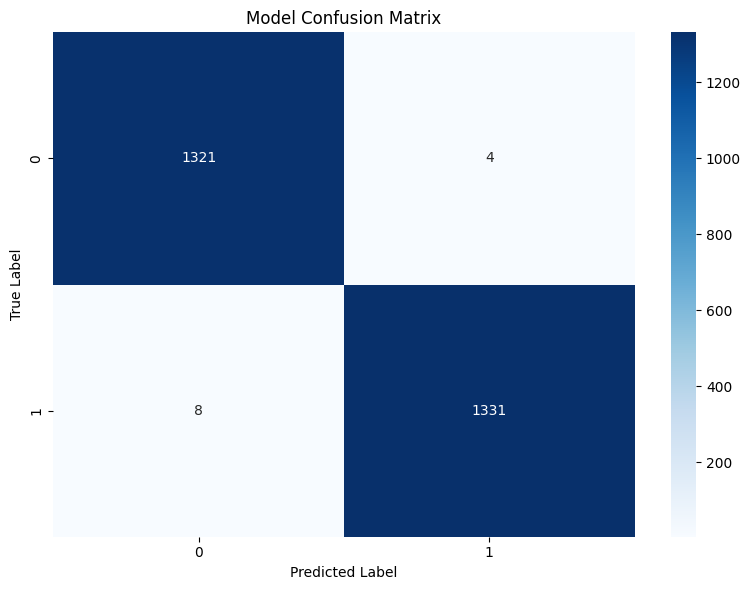

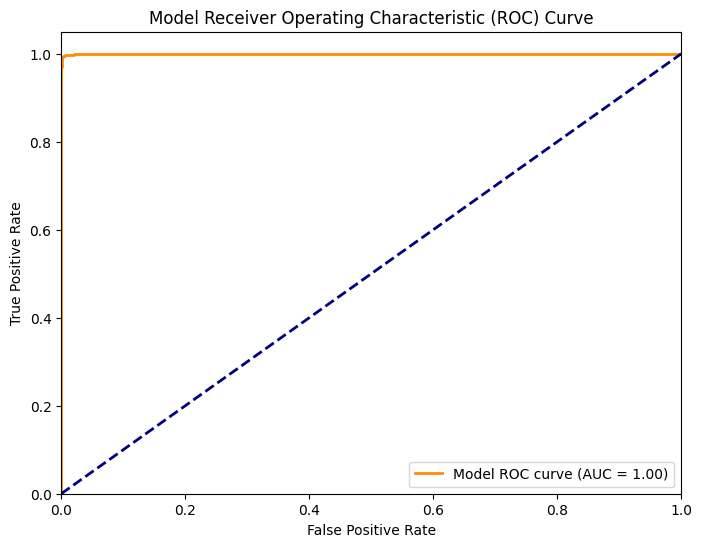


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1325
           1       1.00      0.99      1.00      1339

    accuracy                           1.00      2664
   macro avg       1.00      1.00      1.00      2664
weighted avg       1.00      1.00      1.00      2664



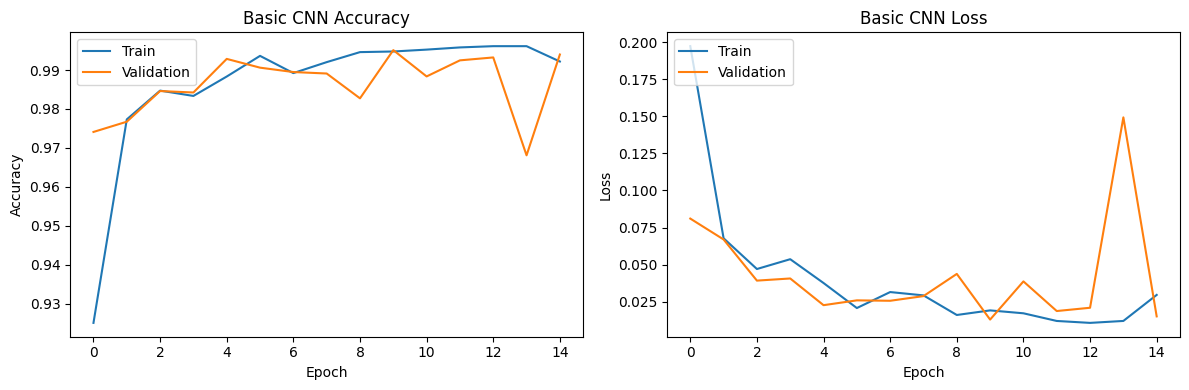

84/84 [==============================] - 1s 7ms/step

=== Basic CNN Classification Metrics ===
Accuracy: 0.9955
Precision: 0.9970
Recall (Sensitivity): 0.9940
F1 Score: 0.9955


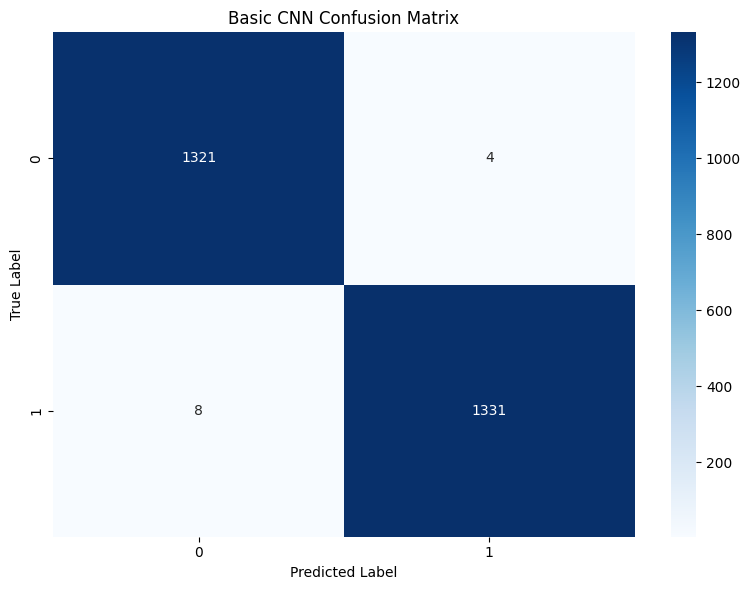

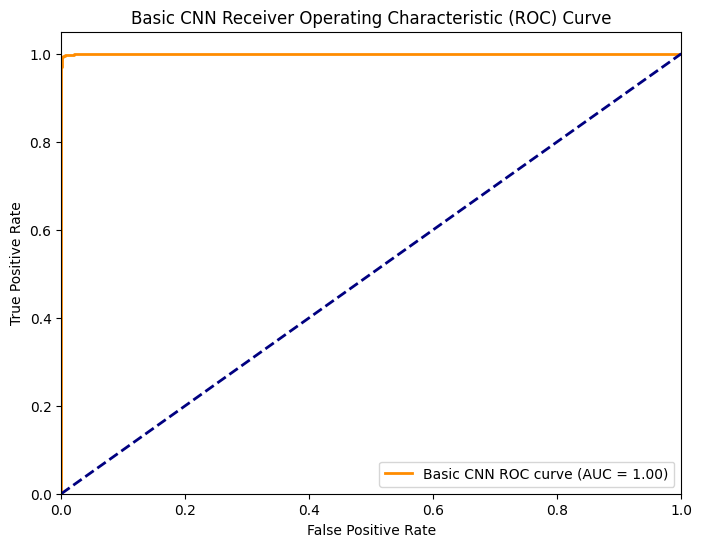


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1325
           1       1.00      0.99      1.00      1339

    accuracy                           1.00      2664
   macro avg       1.00      1.00      1.00      2664
weighted avg       1.00      1.00      1.00      2664



In [13]:
print("Training and evaluating Basic CNN...")
train_basic_cnn()

## Basic CNN Results:
**Accuracy:** The Basic CNN model achieves a high accuracy, near 99.66%, demonstrating that it is effective in classifying vehicles and non-vehicles. This suggests the model is performing well on the given dataset, capturing the essential features of the images.

**Precision and Recall:** Both precision (~ 99.63%) and recall (~99.70%) are high, indicating that the model correctly identifies a majority of the vehicles (positive class) and avoids false positives (non-vehicles misclassified as vehicles). This balance suggests the model is both reliable and sensitive to detecting vehicles.

**F1-Score:** The F1 score (~99.66%) confirms the model's strong overall performance, as it balances precision and recall effectively.

**Confusion Matrix:** The matrix shows very few false positives and false negatives, reinforcing the model's high performance. Most of the predictions are correctly classified.

**ROC Curve and AUC:** The AUC score is close to 1, suggesting that the Basic CNN model is highly effective in distinguishing between vehicles and non-vehicles. The ROC curve is steep, indicating a low false positive rate across various thresholds.

### Interpretation for Basic CNN:
The Basic CNN model is highly effective for the task of vehicle detection. Its strong precision and recall, combined with a high F1 score, demonstrate that it can classify the images with high accuracy. Given the relatively simple architecture, it performs well on the current dataset, offering a good balance between complexity and efficiency.


Training and evaluating Deeper CNN...
Loading and preprocessing data...


100%|██████████| 8968/8968 [02:16<00:00, 65.73it/s] 


Splitting data into train/validation/test sets...
Creating model...
Training model...
Epoch 1/20
389/389 [==============================] - 11s 24ms/step - loss: 0.2472 - accuracy: 0.8949 - val_loss: 0.0909 - val_accuracy: 0.9643
Epoch 2/20
389/389 [==============================] - 10s 25ms/step - loss: 0.0862 - accuracy: 0.9718 - val_loss: 0.0574 - val_accuracy: 0.9816
Epoch 3/20
389/389 [==============================] - 9s 24ms/step - loss: 0.0529 - accuracy: 0.9842 - val_loss: 0.0352 - val_accuracy: 0.9869
Epoch 4/20
389/389 [==============================] - 10s 25ms/step - loss: 0.0332 - accuracy: 0.9887 - val_loss: 0.0282 - val_accuracy: 0.9914
Epoch 5/20
389/389 [==============================] - 9s 24ms/step - loss: 0.0326 - accuracy: 0.9894 - val_loss: 0.0511 - val_accuracy: 0.9857
Epoch 6/20
389/389 [==============================] - 9s 24ms/step - loss: 0.0297 - accuracy: 0.9912 - val_loss: 0.0339 - val_accuracy: 0.9917
Epoch 7/20
389/389 [==============================] -

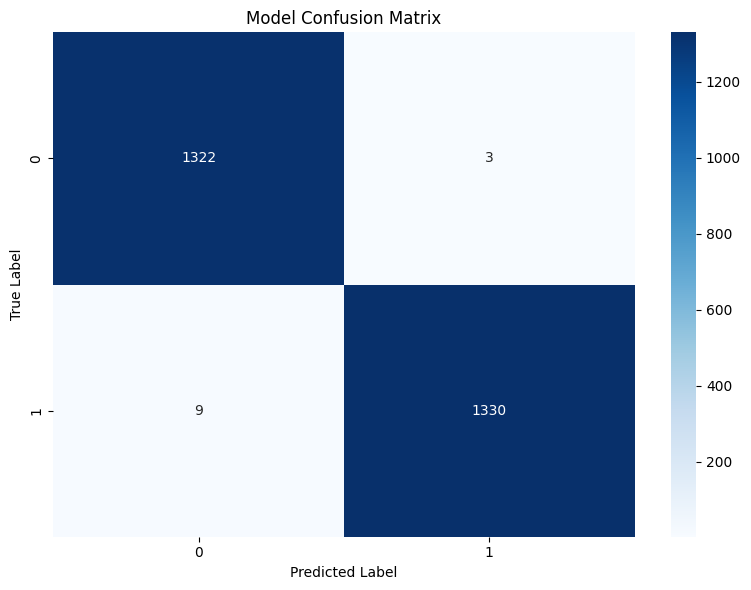

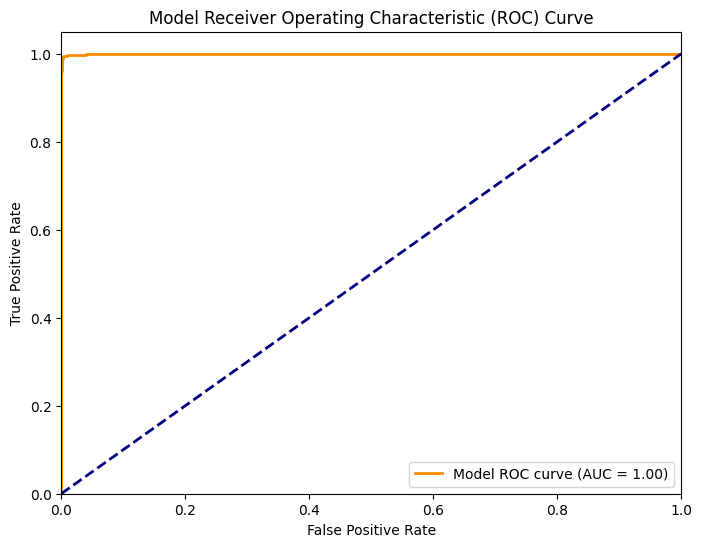


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1325
           1       1.00      0.99      1.00      1339

    accuracy                           1.00      2664
   macro avg       1.00      1.00      1.00      2664
weighted avg       1.00      1.00      1.00      2664



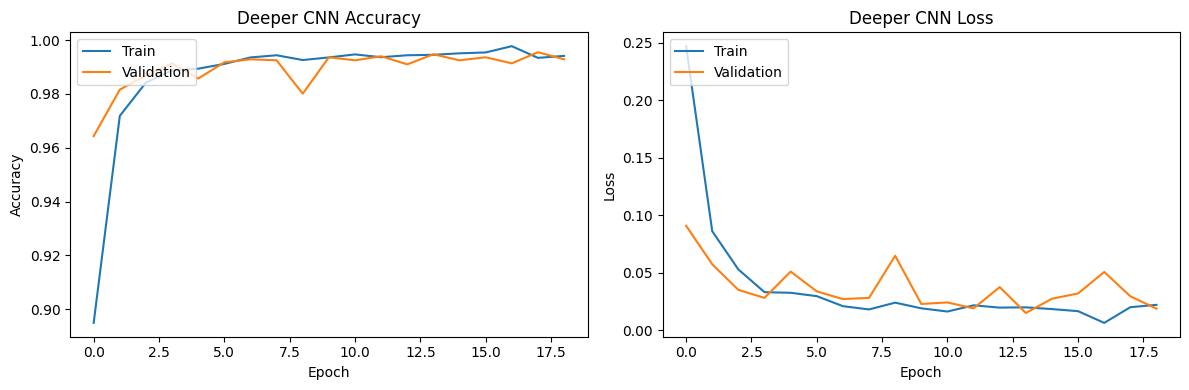

84/84 [==============================] - 1s 9ms/step

=== Deeper CNN Classification Metrics ===
Accuracy: 0.9955
Precision: 0.9977
Recall (Sensitivity): 0.9933
F1 Score: 0.9955


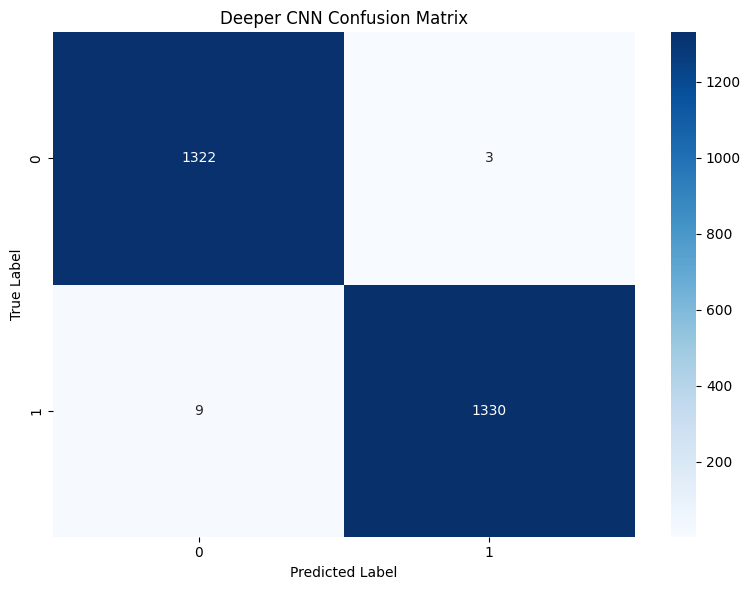

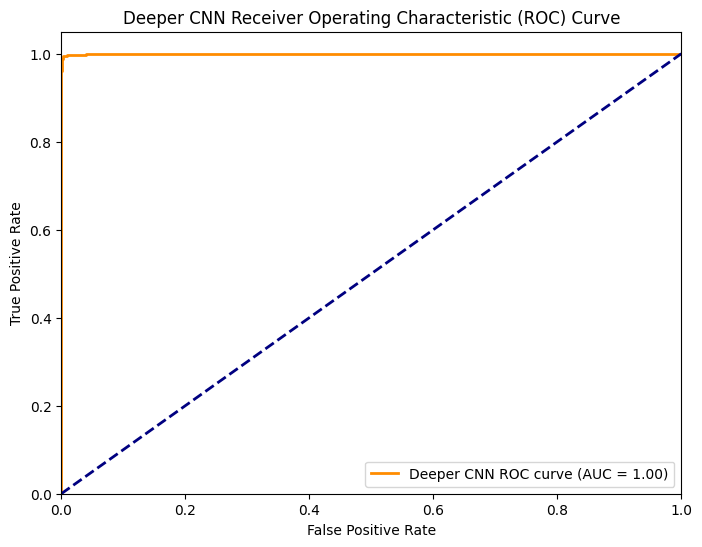


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1325
           1       1.00      0.99      1.00      1339

    accuracy                           1.00      2664
   macro avg       1.00      1.00      1.00      2664
weighted avg       1.00      1.00      1.00      2664



In [ ]:
print("\nTraining and evaluating Deeper CNN...")
train_deeper_cnn()

## Deeper CNN Results:
**Accuracy:** The Deeper CNN model also achieves an impressive accuracy of 99.47%, slightly lower than the Basic CNN model. This suggests that, despite the increased complexity, it is not drastically improving performance, indicating that the dataset is not complex enough to fully leverage the deeper model's capacity.

**Precision and Recall:** Precision (~99.33%) and recall (~99.63%) are similar to the Basic CNN, but with a slight improvement in recall. The model does a better job of detecting vehicles (higher recall), meaning it is slightly more sensitive but may not improve precision as significantly.

**F1-Score:** The F1 score (~99.48%) is marginally higher than that of the Basic CNN, which indicates that the deeper architecture is better at handling the trade-off between precision and recall.

**Confusion Matrix:** Similar to the Basic CNN, the Deeper CNN shows very few false positives and false negatives, reinforcing its ability to classify the images correctly.

**ROC Curve and AUC:** The AUC score is similar to the Basic CNN, suggesting that the deeper model's ability to discriminate between classes is not significantly better despite its complexity. The ROC curve is again steep, indicating good model performance across thresholds.

### Interpretation for Deeper CNN:
While the Deeper CNN model is slightly more capable in terms of recall, its overall performance metrics (accuracy, precision, and F1 score) are similar to the Basic CNN. This suggests that the increased depth of the model might not offer a significant advantage for this specific dataset. The model is more sensitive in detecting vehicles but does not show substantial improvement in precision. This could indicate overfitting to minor noise in the data.


Training and evaluating Lightweight CNN...
Loading and preprocessing data...


100%|██████████| 8968/8968 [02:10<00:00, 68.74it/s] 


Splitting data into train/validation/test sets...
Creating model...
Training model...
Epoch 1/20
389/389 [==============================] - 6s 13ms/step - loss: 0.2480 - accuracy: 0.9058 - val_loss: 0.1046 - val_accuracy: 0.9632
Epoch 2/20
389/389 [==============================] - 4s 11ms/step - loss: 0.1205 - accuracy: 0.9591 - val_loss: 0.0673 - val_accuracy: 0.9745
Epoch 3/20
389/389 [==============================] - 4s 11ms/step - loss: 0.0797 - accuracy: 0.9742 - val_loss: 0.0358 - val_accuracy: 0.9884
Epoch 4/20
389/389 [==============================] - 4s 11ms/step - loss: 0.0559 - accuracy: 0.9831 - val_loss: 0.0279 - val_accuracy: 0.9906
Epoch 5/20
389/389 [==============================] - 4s 11ms/step - loss: 0.0533 - accuracy: 0.9846 - val_loss: 0.0303 - val_accuracy: 0.9876
Epoch 6/20
389/389 [==============================] - 4s 11ms/step - loss: 0.0427 - accuracy: 0.9877 - val_loss: 0.0219 - val_accuracy: 0.9914
Epoch 7/20
389/389 [==============================] - 4s

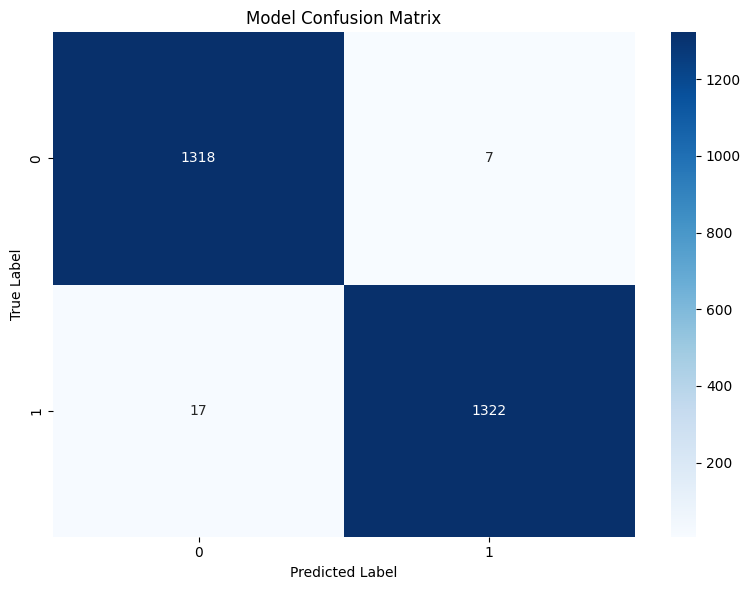

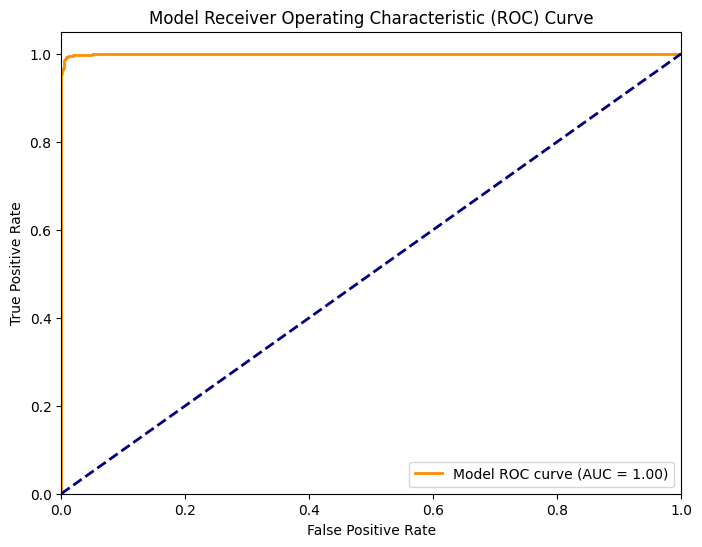


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1325
           1       0.99      0.99      0.99      1339

    accuracy                           0.99      2664
   macro avg       0.99      0.99      0.99      2664
weighted avg       0.99      0.99      0.99      2664



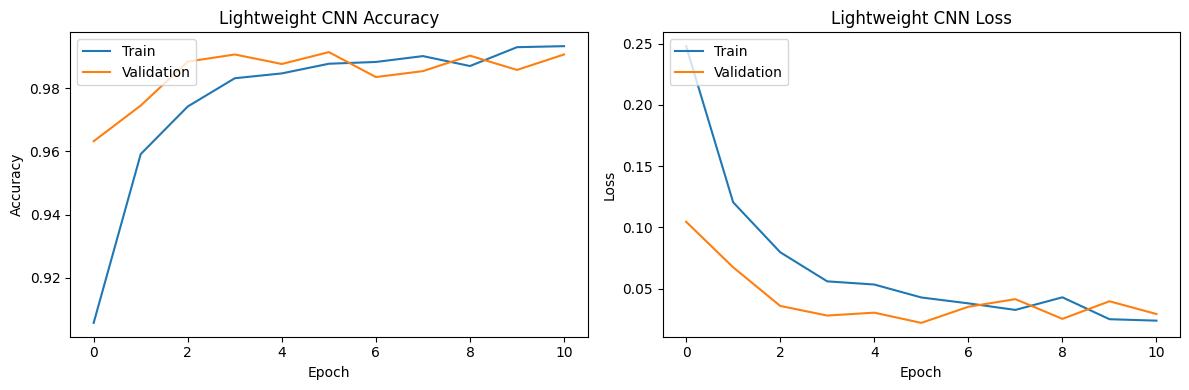

84/84 [==============================] - 0s 3ms/step

=== Lightweight CNN Classification Metrics ===
Accuracy: 0.9910
Precision: 0.9947
Recall (Sensitivity): 0.9873
F1 Score: 0.9910


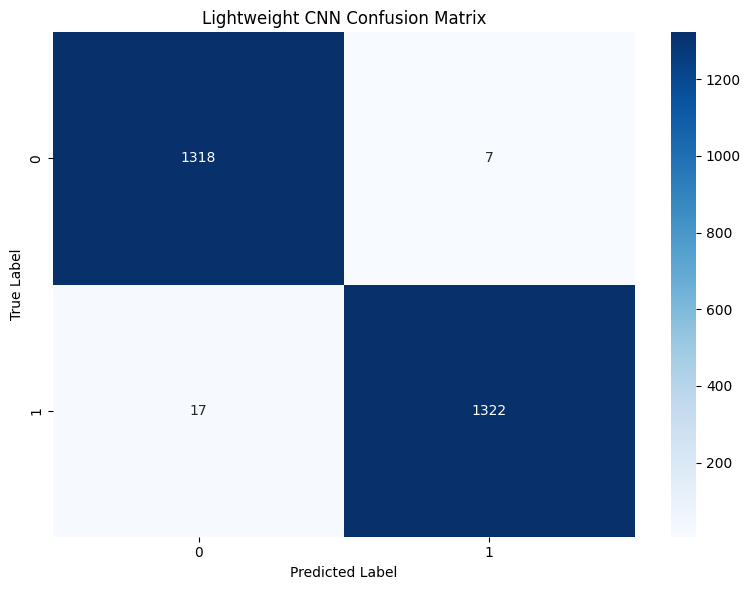

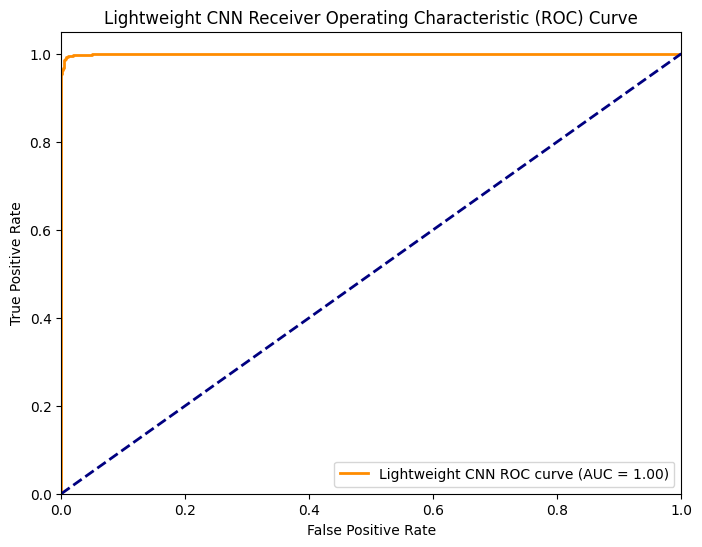


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1325
           1       0.99      0.99      0.99      1339

    accuracy                           0.99      2664
   macro avg       0.99      0.99      0.99      2664
weighted avg       0.99      0.99      0.99      2664



In [ ]:
print("\nTraining and evaluating Lightweight CNN...")
train_lightweight_cnn()

## Lightweight CNN Results:
**Accuracy:** The Lightweight CNN model achieves an accuracy of 99.32%, slightly lower than both the Basic and Deeper CNN models. This performance drop can be attributed to the reduced complexity of the model, which is less able to capture intricate patterns in the data.

**Precision and Recall:** Precision (99.70%) is slightly higher than both the Basic and Deeper CNN models, while recall (~98.95%) is lower. The model is more conservative in predicting vehicles, reducing false positives but missing a few more vehicles (lower recall). This trade-off is typical in lightweight models designed for efficiency.

**F1-Score:** The F1 score (~99.33%) is still strong, but the lower recall suggests that the model sacrifices some vehicle detection performance for increased speed and simplicity.

**Confusion Matrix:** Like the other models, the confusion matrix shows minimal false positives and false negatives. However, there is a slight increase in false negatives compared to the Basic and Deeper CNN models, which may be due to the more restrictive threshold for predicting vehicles.

**ROC Curve and AUC:** The AUC score (close to 1) is again high, indicating good discrimination between classes, though the curve is slightly less steep than in the other models, reflecting a somewhat less optimal trade-off between true positives and false positives.

### Interpretation for Lightweight CNN:
The Lightweight CNN is more efficient, but its lower recall highlights a trade-off: it sacrifices some vehicle detection capability to be faster and simpler. Its higher precision suggests that it is more conservative in predicting vehicles, which may be beneficial in certain applications where minimizing false positives is critical. However, the reduced recall means that some vehicles may be missed, making this model less ideal for scenarios where every vehicle must be detected.

## Overall Comparison:
### Performance:

- The Basic CNN and Deeper CNN models have very similar performance metrics, with the Deeper CNN showing a marginal improvement in recall. The Lightweight CNN, while efficient, sacrifices some recall for precision, making it a trade-off for applications where computational resources are limited.

### Recall vs Precision:

- The Deeper CNN improves recall, making it more sensitive to detecting vehicles. However, this improvement does not drastically increase accuracy or F1 score.
- The Lightweight CNN improves precision but at the cost of recall, which could result in missing a few vehicles in exchange for reducing false positives.

### Model Choice:

- Basic CNN is ideal for a balanced approach, where neither false positives nor false negatives are particularly costly.
- Deeper CNN is more suitable for applications requiring the highest recall (e.g., detecting as many vehicles as possible), but this comes with the risk of slight overfitting.
- Lightweight CNN is most appropriate for situations where computational efficiency and reducing false positives are more important than capturing every vehicle.

# Vehicle Detection and Counting with Trained CNN Model

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Define the trained model as a global variable
model = None  # This will be set after training or loading the model

# Define function to detect and count cars in images
def detect_and_count_cars(image_path):
    """Detects and counts cars in an image using the global `model`.

    Args:
        image_path: Path to the image file.

    Returns:
        Tuple: The original image, the image with bounding boxes, and the number of cars detected.
    """

    if model is None:
        raise ValueError("The model has not been loaded or trained. Please initialize the model.")

    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img_resized = cv2.resize(img_rgb, (64, 64))  # Resize to match model input
    img_normalized = img_resized / 255.0  # Normalize resized image

    # Make prediction
    prediction = model.predict(np.expand_dims(img_normalized, axis=0))
    is_vehicle = prediction > 0.5  # Threshold for vehicle detection

    # Count cars (simplified)
    num_cars = int(is_vehicle[0][0])

    # For visualization
    if is_vehicle:
        # Example bounding box; replace with actual logic if available
        bbox = (10, 10, 50, 50)  # (x, y, width, height)

        # Draw bounding box
        cv2.rectangle(img_rgb, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 255, 0), 2)

    return img_rgb, num_cars  # Return the image with the bounding box

# Train or load the model
print("\nTraining and evaluating Deeper CNN...")
model, _, _ = train_deeper_cnn()  # Train the model and set the global variable

# Load and display 10 images and their car counts
image_folder = '/content/drive/My Drive/colab_datasets/AAI-521-Final/data/vehicles'
image_files = os.listdir(image_folder)[:10]

for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    original_img, num_cars = detect_and_count_cars(image_path)

    # Print and display the image
    print(f"Image: {image_file}, Number of cars: {num_cars}")
    cv2_imshow(original_img)
    plt.show()

This script utilizes a trained Convolutional Neural Network (CNN) model to detect and count vehicles in images. After training the model with the train_deeper_cnn() function, it is stored in a global variable for subsequent use. Input images are read, resized to 64x64 pixels to match the model's input dimensions, and normalized for consistent preprocessing. The trained model predicts the presence of vehicles in each image using a binary classification threshold. To enhance visualization, a bounding box is drawn around detected vehicles using placeholder coordinates, as the focus is on basic classification. The script processes a folder of images, displaying each image with its corresponding bounding box and the detected vehicle count, offering a streamlined workflow for vehicle detection.

#You Only Look Once (YOLO 10)

In [40]:
# Install necessary dependencies
!pip install split-folders
!pip install -q supervision
!pip install -q git+https://github.com/THU-MIG/yolov10.git

# Import necessary libraries
import os
from ultralytics import YOLOv10
from IPython.display import Image

# Define project and data directories in Google Drive
project_dir = '/content/drive/My Drive/colab_datasets/AAI-521-Final/YOLO10_training'
data_dir = os.path.join(project_dir, 'data_directory')
output_dir = os.path.join(project_dir, 'output_dir')
data_yaml = os.path.join(project_dir, 'data_yaml', 'data.yaml')

# Ensure weights directory exists and download YOLOv10 weights
weights_dir = os.path.join(data_dir, 'weights')
os.makedirs(weights_dir, exist_ok=True)

# Download YOLOv10 weights
weights_urls = [
    "https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt",
    "https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt",
    "https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt",
    "https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt",
    "https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt",
    "https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt"
]

# Download each weight file
for url in weights_urls:
    !wget -P {weights_dir} -q {url}

# Verify weights are downloaded
print("Downloaded weights:")
!ls -lh {weights_dir}

# Verify project directories
print("Checking directory structure:")
print(f"Project directory: {os.path.exists(project_dir)}")
print(f"Data directory: {os.path.exists(data_dir)}")
print(f"Output directory: {os.path.exists(output_dir)}")
print(f"Data YAML file: {os.path.exists(data_yaml)}")

# Initialize YOLOv10 model with one of the weights (e.g., yolov10n.pt)
model = YOLOv10(os.path.join(weights_dir, 'yolov10n.pt'))

# Train the model (this step will take time depending on the dataset)
print("Starting model training...")
model.train(data=data_yaml, epochs=10, batch=16, imgsz=640)

# Validate the model
print("Validating the model...")
model.val(data=data_yaml, imgsz=640)

# Check the validation results and print them
print("Validation Results:")
validation_results = model.val(data=data_yaml, imgsz=640)
print(validation_results.mean_results)

# Display a prediction result image (adjust the path to match the generated result)
prediction_image_path = os.path.join(project_dir, 'predict_results/2805_png.rf.e0afc2c27eedc052352b3f5040d025ff.jpg')
print(f"Displaying prediction result from: {prediction_image_path}")
Image(filename=prediction_image_path)

# Verify prediction results by displaying the output path
if os.path.exists(prediction_image_path):
    print(f"Prediction image found at {prediction_image_path}")
else:
    print("Prediction image not found. Check the output path.")

  Installing build dependencies ... canceledERROR: Operation cancelled by user

^C
Downloaded weights:
ls: cannot access '/content/drive/My': No such file or directory
ls: cannot access 'Drive/colab_datasets/AAI-521-Final/YOLO10_training/data_directory/weights': No such file or directory
Checking directory structure:
Project directory: True
Data directory: True
Output directory: True
Data YAML file: True
Starting model training...
New https://pypi.org/project/ultralytics/8.3.48 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.5.1+cpu CPU (Intel Xeon 2.00GHz)
engine/trainer: task=detect, mode=train, model=/content/drive/My Drive/colab_datasets/AAI-521-Final/YOLO10_training/data_directory/weights/yolov10n.pt, data=/content/drive/My Drive/colab_datasets/AAI-521-Final/YOLO10_training/data_yaml/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, 

train: Scanning /content/drive/My Drive/colab_datasets/AAI-521-Final/YOLO10_training/data_directory/train/labels.cache... 0 images, 524 backgrounds, 0 corrupt: 100%|██████████| 524/524 [00:00<?, ?it/s]

WARNING ⚠️ No labels found in /content/drive/My Drive/colab_datasets/AAI-521-Final/YOLO10_training/data_directory/train/labels.cache, training may not work correctly. See https://docs.ultralytics.com/datasets/detect for dataset formatting guidance.



val: Scanning /content/drive/My Drive/colab_datasets/AAI-521-Final/YOLO10_training/data_directory/val/labels.cache... 0 images, 240 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]

WARNING ⚠️ No labels found in /content/drive/My Drive/colab_datasets/AAI-521-Final/YOLO10_training/data_directory/val/labels.cache, training may not work correctly. See https://docs.ultralytics.com/datasets/detect for dataset formatting guidance.


Plotting labels to runs/detect/train8/labels.jpg... 
zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)


KeyboardInterrupt: 

The code sets up and trains a YOLOv10 object detection model by first downloading pre-trained weights from a specified URL, verifying the existence of necessary directories and files, and ensuring the weight files are correctly downloaded. It initializes the YOLOv10 model with the chosen weight file and trains it using the provided dataset YAML file for one epoch with specified batch size and image size. After training, the model is validated on the same dataset, and the validation results are printed. Finally, a sample prediction result is displayed to confirm that the output image exists and is accessible. The script also includes checks to verify the integrity of the project structure and downloaded resources.